In [5]:
# import 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor


In [6]:
# use shufflesplit for cross validation

shuffle_split_cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

# lets load the data and split into training and test
features, labels = fetch_california_housing(as_frame = True, return_X_y = True)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state = 42)

# Linear Regression Classifier:

In [10]:
lin_reg_pipe = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
    ])

lin_reg_cv_results = cross_validate(lin_reg_pipe, train_features, train_labels,
                                   cv= shuffle_split_cv, 
                                   scoring = 'neg_mean_absolute_error',
                                   n_jobs = True)

lin_reg_errors = pd.Series(-lin_reg_cv_results['test_score'],
                           name = 'Linear Regression Error')

# Dummy Regressor

In [11]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
  baseline_model_median = DummyRegressor(strategy=strategy,
                                         constant=constant_val,
                                         quantile=quantile_val)

  baseline_median_cv_results = cross_validate(baseline_model_median,
                                              train_features,
                                              train_labels,
                                              cv=shuffle_split_cv,
                                              scoring="neg_mean_absolute_error",
                                              n_jobs=2)
  
  return pd.Series(-baseline_median_cv_results["test_score"],
                   name="Dummy regressor error")

In [13]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(strategy='constant',
                                                               constant_val=2)
baseline_quantile_cv_results_errors = dummy_regressor_baseline(strategy='quantile', 
                                                               quantile_val=0.55)

In [14]:
# compare the performance of dummy regressors

dummy_error_df = pd.concat([baseline_median_cv_results_errors,
                            baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors,
                            baseline_quantile_cv_results_errors], axis=1)

dummy_error_df.columns = ['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']


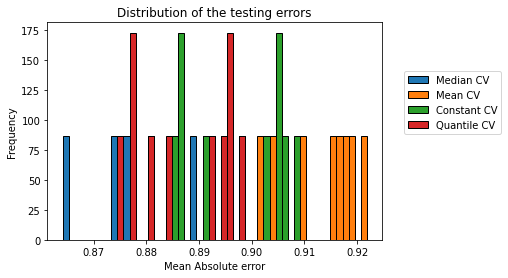

In [15]:
dummy_error_df.plot.hist(bins=50, density = True, edgecolor = 'black')
plt.legend(bbox_to_anchor = [1.05, 0.8], loc = 'upper left')
plt.xlabel('Mean Absolute error')
_ = plt.title("Distribution of the testing errors")

# Permutation Test Score

It permutes the target to generate randomized data and computes the empirical p-value against
the null hypothesis, that features and targets are independent.

Here we are interested in permutation_score returned by this API, which indicates score of the
model on different permutations.

In [18]:
score, permutation_score, pvalue = permutation_test_score(lin_reg_pipe,
                                                          train_features,
                                                          train_labels,
                                                          cv=shuffle_split_cv,
                                                          scoring="neg_mean_absolute_error",
                                                          n_jobs=2,
                                                          n_permutations=30)
permutation_errors = pd.Series(-permutation_score, name="Permuted error")

print(permutation_score)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


# Model comparison

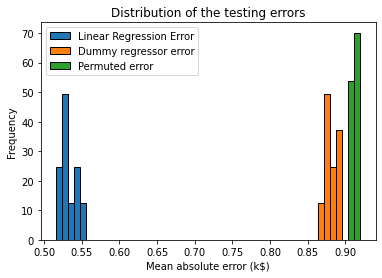

In [19]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_errors],axis=1)

error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

Our model has better performance than the two baselines. However our model needs to improve
it further.